In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 16.8 MB/s 
     |████████████████████████████████| 4.6 MB 5.2 MB/s 
     |████████████████████████████████| 280 kB 12.9 MB/s 


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'Grad-CAM'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [6]:
torch.manual_seed(123456)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [7]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# **Model Designing**

In [28]:
from torch.nn.modules import activation

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        #self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = torch.nn.functional.elu(x)

        x = self.conv2(x, edge_index)
        x_last_Conv = torch.nn.functional.elu(x)

        #x = self.conv3(x, edge_index)
        #x = torch.nn.functional.elu(x)

        # 2. Readout layer
        x_GAP = global_mean_pool(x_last_Conv, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        #x_GAP = F.dropout(x_GAP, p=0.5, training=self.training)
        x_final = self.lin(x_GAP)
        x_Final = F.softmax(x_final, dim=1)
        
        return x_last_Conv, x_Final


Grad_CAM_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
print(Grad_CAM_model_GCN)

GCN(
  (conv1): GCNConv(7, 7)
  (conv2): GCNConv(7, 7)
  (lin): Linear(in_features=7, out_features=2, bias=True)
)


In [29]:
Grad_CAM_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
Grad_CAM_model_GCN.eval()

GCN(
  (conv1): GCNConv(7, 7)
  (conv2): GCNConv(7, 7)
  (lin): Linear(in_features=7, out_features=2, bias=True)
)

In [30]:
Grad_CAM_optimizer = torch.optim.Adam(Grad_CAM_model_GCN.parameters(), lr=0.001)

In [31]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
  loss_per_epoch = criterion(preds, gtruth)
  return loss_per_epoch

In [32]:
def loading_model(load_index):
  Grad_CAM_model_GCN = GCN(hidden_channels=size_of_hidden_layers)
  CAM_optimizer = torch.optim.Adam(params = Grad_CAM_model_GCN.parameters(), lr=1e-4)
  checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/model_classifier"+str(load_index)+".pt")
  Grad_CAM_model_GCN.load_state_dict(checkpoint['model_state_dict'])
  Grad_CAM_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']


  return Grad_CAM_model_GCN, Grad_CAM_optimizer, epoch

In [33]:
def visualize_losses(grad_cam_losses, epoch_history):
  grad_cam_losses_list = torch.stack(grad_cam_losses).cpu().detach().numpy()

  fig = plt.figure(figsize=(27,20))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title("CAM Model Loss in Epoch: " + str(epoch_history))

  ax.plot(grad_cam_losses_list, color='r')

  plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Loss_til_epoch_{:04d}.png'.format(epoch_history))
  plt.show()  




# **Traning Configurations**

In [34]:
def train_step():
  Grad_CAM_loss_batch = []

  Grad_CAM_model_GCN.train()
  Grad_CAM_optimizer.zero_grad()
  for batched_data in train_loader:
    Grad_CAM_Training_Last_Conv, Grad_CAM_out = Grad_CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    Grad_CAM_loss = loss_calculations(Grad_CAM_out, batched_data.y)
    Grad_CAM_loss_batch.append(Grad_CAM_loss)
    Grad_CAM_loss.backward()
    Grad_CAM_optimizer.step()

  Grad_CAM_optimizer.step()

  return torch.mean(torch.tensor(Grad_CAM_loss_batch))


In [35]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [36]:
def train(EPOCHS, load_index):
  Grad_CAM_training_loss_per_epoch = []

  for epoch in range(EPOCHS):
    Grad_CAM_model_training_loss = train_step()
    print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {Grad_CAM_model_training_loss:.4f}')

    Grad_CAM_training_loss_per_epoch.append(Grad_CAM_model_training_loss)
    #break

    if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
      visualize_losses(Grad_CAM_training_loss_per_epoch, epoch + load_index + 1)
    if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
      torch.save({'epoch': epoch+load_index+1, 'model_state_dict': Grad_CAM_model_GCN.state_dict(), 'optimizer_state_dict': Grad_CAM_optimizer.state_dict(), 'loss': Grad_CAM_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier" + str(epoch + load_index + 1)+".pt")

  
  #return model_loss





<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-37-d17a5d269471>:3: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if load_index is not 0:


Epoch: 001, Grad-CAM Model Loss: 0.6932
Epoch: 002, Grad-CAM Model Loss: 0.6899
Epoch: 003, Grad-CAM Model Loss: 0.6854
Epoch: 004, Grad-CAM Model Loss: 0.6843
Epoch: 005, Grad-CAM Model Loss: 0.6811
Epoch: 006, Grad-CAM Model Loss: 0.6817
Epoch: 007, Grad-CAM Model Loss: 0.6723
Epoch: 008, Grad-CAM Model Loss: 0.6764
Epoch: 009, Grad-CAM Model Loss: 0.6758
Epoch: 010, Grad-CAM Model Loss: 0.6566
Epoch: 011, Grad-CAM Model Loss: 0.6606
Epoch: 012, Grad-CAM Model Loss: 0.6537
Epoch: 013, Grad-CAM Model Loss: 0.6464
Epoch: 014, Grad-CAM Model Loss: 0.6608
Epoch: 015, Grad-CAM Model Loss: 0.6505
Epoch: 016, Grad-CAM Model Loss: 0.6544
Epoch: 017, Grad-CAM Model Loss: 0.6617
Epoch: 018, Grad-CAM Model Loss: 0.6511
Epoch: 019, Grad-CAM Model Loss: 0.6525
Epoch: 020, Grad-CAM Model Loss: 0.6525
Epoch: 021, Grad-CAM Model Loss: 0.6509
Epoch: 022, Grad-CAM Model Loss: 0.6341
Epoch: 023, Grad-CAM Model Loss: 0.6291
Epoch: 024, Grad-CAM Model Loss: 0.6309
Epoch: 025, Grad-CAM Model Loss: 0.6390


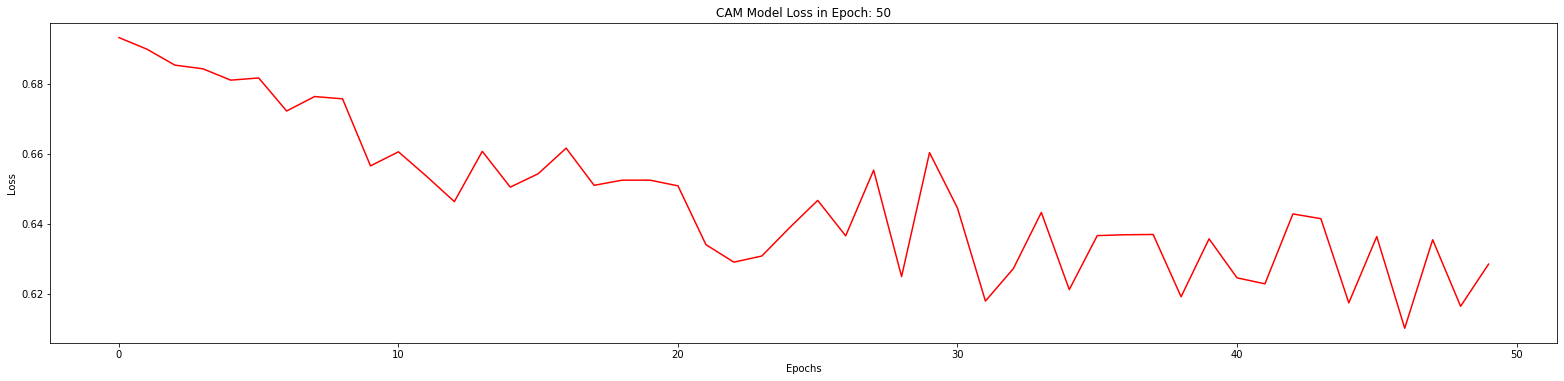

Epoch: 051, Grad-CAM Model Loss: 0.6343
Epoch: 052, Grad-CAM Model Loss: 0.6545
Epoch: 053, Grad-CAM Model Loss: 0.6149
Epoch: 054, Grad-CAM Model Loss: 0.6276
Epoch: 055, Grad-CAM Model Loss: 0.6595
Epoch: 056, Grad-CAM Model Loss: 0.6521
Epoch: 057, Grad-CAM Model Loss: 0.6088
Epoch: 058, Grad-CAM Model Loss: 0.6506
Epoch: 059, Grad-CAM Model Loss: 0.6394
Epoch: 060, Grad-CAM Model Loss: 0.6460
Epoch: 061, Grad-CAM Model Loss: 0.6439
Epoch: 062, Grad-CAM Model Loss: 0.5954
Epoch: 063, Grad-CAM Model Loss: 0.6077
Epoch: 064, Grad-CAM Model Loss: 0.6324
Epoch: 065, Grad-CAM Model Loss: 0.6367
Epoch: 066, Grad-CAM Model Loss: 0.6308
Epoch: 067, Grad-CAM Model Loss: 0.6200
Epoch: 068, Grad-CAM Model Loss: 0.6241
Epoch: 069, Grad-CAM Model Loss: 0.6239
Epoch: 070, Grad-CAM Model Loss: 0.6284
Epoch: 071, Grad-CAM Model Loss: 0.6302
Epoch: 072, Grad-CAM Model Loss: 0.6342
Epoch: 073, Grad-CAM Model Loss: 0.6354
Epoch: 074, Grad-CAM Model Loss: 0.6172
Epoch: 075, Grad-CAM Model Loss: 0.6447


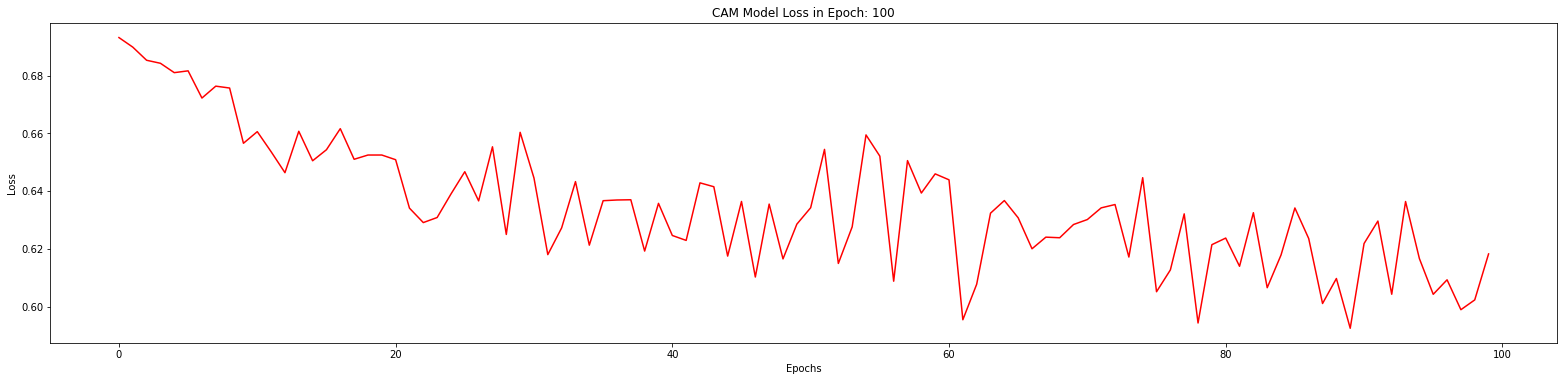

Epoch: 101, Grad-CAM Model Loss: 0.6077
Epoch: 102, Grad-CAM Model Loss: 0.6144
Epoch: 103, Grad-CAM Model Loss: 0.6096
Epoch: 104, Grad-CAM Model Loss: 0.6107
Epoch: 105, Grad-CAM Model Loss: 0.6020
Epoch: 106, Grad-CAM Model Loss: 0.5892
Epoch: 107, Grad-CAM Model Loss: 0.5889
Epoch: 108, Grad-CAM Model Loss: 0.6041
Epoch: 109, Grad-CAM Model Loss: 0.6198
Epoch: 110, Grad-CAM Model Loss: 0.6024
Epoch: 111, Grad-CAM Model Loss: 0.6032
Epoch: 112, Grad-CAM Model Loss: 0.5855
Epoch: 113, Grad-CAM Model Loss: 0.6242
Epoch: 114, Grad-CAM Model Loss: 0.5951
Epoch: 115, Grad-CAM Model Loss: 0.6076
Epoch: 116, Grad-CAM Model Loss: 0.5930
Epoch: 117, Grad-CAM Model Loss: 0.5914
Epoch: 118, Grad-CAM Model Loss: 0.6062
Epoch: 119, Grad-CAM Model Loss: 0.5880
Epoch: 120, Grad-CAM Model Loss: 0.5933
Epoch: 121, Grad-CAM Model Loss: 0.5861
Epoch: 122, Grad-CAM Model Loss: 0.5971
Epoch: 123, Grad-CAM Model Loss: 0.5889
Epoch: 124, Grad-CAM Model Loss: 0.5739
Epoch: 125, Grad-CAM Model Loss: 0.5868


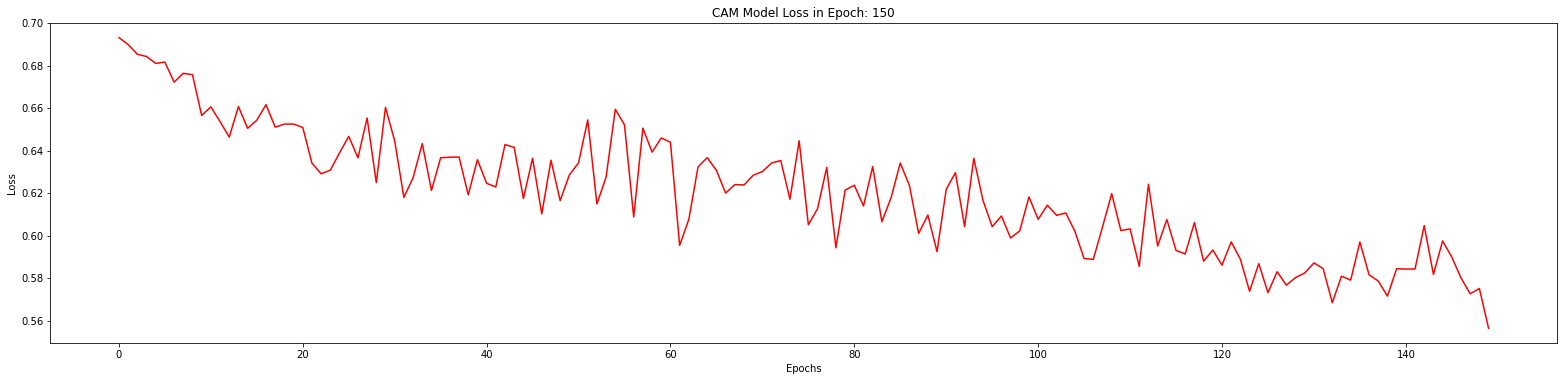

Epoch: 151, Grad-CAM Model Loss: 0.5707
Epoch: 152, Grad-CAM Model Loss: 0.5885
Epoch: 153, Grad-CAM Model Loss: 0.5607
Epoch: 154, Grad-CAM Model Loss: 0.5788
Epoch: 155, Grad-CAM Model Loss: 0.6040
Epoch: 156, Grad-CAM Model Loss: 0.5900
Epoch: 157, Grad-CAM Model Loss: 0.5913
Epoch: 158, Grad-CAM Model Loss: 0.5652
Epoch: 159, Grad-CAM Model Loss: 0.5850
Epoch: 160, Grad-CAM Model Loss: 0.5540
Epoch: 161, Grad-CAM Model Loss: 0.5617
Epoch: 162, Grad-CAM Model Loss: 0.5607
Epoch: 163, Grad-CAM Model Loss: 0.5591
Epoch: 164, Grad-CAM Model Loss: 0.5682
Epoch: 165, Grad-CAM Model Loss: 0.5899
Epoch: 166, Grad-CAM Model Loss: 0.5891
Epoch: 167, Grad-CAM Model Loss: 0.5650
Epoch: 168, Grad-CAM Model Loss: 0.5663
Epoch: 169, Grad-CAM Model Loss: 0.5737
Epoch: 170, Grad-CAM Model Loss: 0.5539
Epoch: 171, Grad-CAM Model Loss: 0.5649
Epoch: 172, Grad-CAM Model Loss: 0.5808
Epoch: 173, Grad-CAM Model Loss: 0.5682
Epoch: 174, Grad-CAM Model Loss: 0.5547
Epoch: 175, Grad-CAM Model Loss: 0.5665


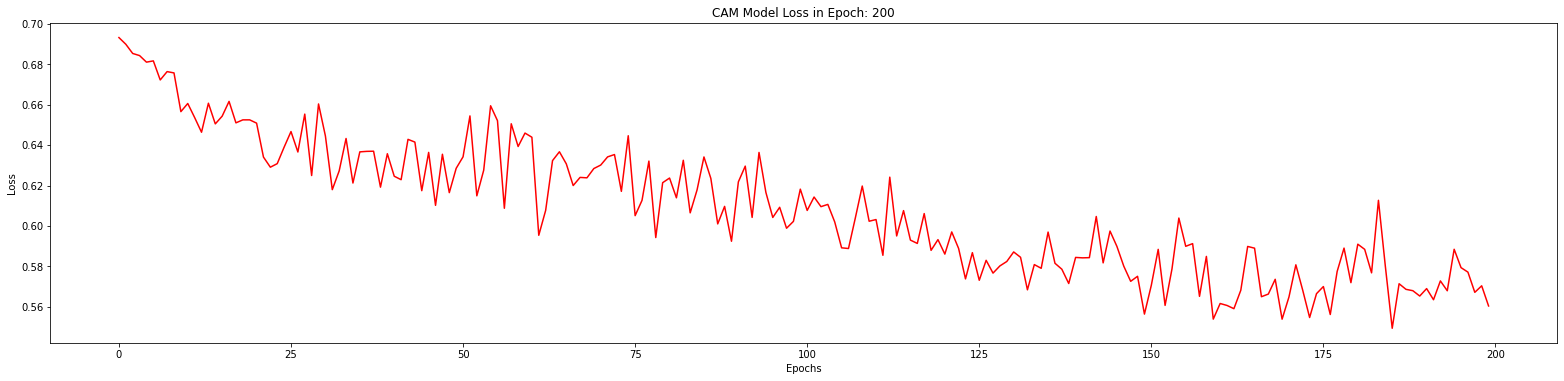

In [37]:
EPOCHS = 200
load_index = 0
if load_index is not 0:
  model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [38]:
def Grad_CAM_test(test_loader):
  Grad_CAM_model_GCN.eval()
  correct = 0
  for batched_data in test_loader:  
    Grad_CAM_Test_Last_Conv, Grad_CAM_test_out = Grad_CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)  
    Grad_CAM_test_pred = Grad_CAM_test_out.argmax(dim=1) 
    #print(Grad_CAM_test_pred) 
    correct += int((Grad_CAM_test_pred == batched_data.y).sum())  
  return correct / len(test_loader.dataset)  

In [39]:
Grad_CAM_test_acc = Grad_CAM_test(test_loader)
print(f'Test Accuracy: {Grad_CAM_test_acc:.4f}')

Test Accuracy: 0.7368


In [ ]:
print(Grad_CAM_model_GCN.conv1)
StateDict = Grad_CAM_model_GCN.state_dict() # STATE DICT is for Weights and Biases
print(StateDict.keys())
whole_weights = StateDict.items()
#print(whole_weights)


Conv1_biases = StateDict.get('conv1.bias')
Conv1_Weights = StateDict.get('conv1.lin.weight')

Conv2_biases = StateDict.get('conv2.bias')
Conv2_Weights = StateDict.get('conv2.lin.weight')

Conv3_biases = StateDict.get('conv3.bias')
Conv3_Weights = StateDict.get('conv3.lin.weight')

Dense_biases = StateDict.get('lin.bias')
Dense_Weights = StateDict.get('lin.weight')

print(f'Length of CONV1_Weights: {len(Conv1_Weights)}')
print(f'Length of CONV1.Bias: {len(Conv1_biases)}')

print(f'Length of CONV2_Weights: {len(Conv2_Weights)}')
print(f'Length of CONV2.Bias: {len(Conv2_biases)}')

print(f'Length of CONV3_Weights: {len(Conv3_Weights)}')
print(f'Length of CONV3.Bias: {len(Conv3_biases)}')

print(f'Length of Dense_Weights: {len(Dense_Weights)}')
print(f'Length of Dense.Bias: {len(Dense_biases)}')


GCNConv(7, 7)
odict_keys(['conv1.bias', 'conv1.lin.weight', 'conv2.bias', 'conv2.lin.weight', 'conv3.bias', 'conv3.lin.weight', 'lin.weight', 'lin.bias'])
Length of CONV1_Weights: 7
Length of CONV1.Bias: 7
Length of CONV2_Weights: 7
Length of CONV2.Bias: 7
Length of CONV3_Weights: 7
Length of CONV3.Bias: 7
Length of Dense_Weights: 2
Length of Dense.Bias: 2


In [ ]:
print(Dense_Weights)

tensor([[-0.6171, -1.2386, -1.1665,  0.0028,  0.5823, -0.3089,  0.2240],
        [ 1.1214,  1.2313,  1.1566,  0.1151, -0.6268, -0.0025,  0.4217]])


# **Gradients of the Last Conv Layer**

In [ ]:
def accumulate_gradients(model_for_you):
  gradients_of_the_Third_Conv_Bias = []
  gradients_of_the_Third_Conv_Weight = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      gradients_of_the_First_Conv_Bias = param.grad.detach().clone()

    if name == "conv1.lin.weight":
      gradients_of_the_First_Conv_Weight = param.grad.detach().clone()

    if name == "conv2.bias":
      gradients_of_the_Second_Conv_Bias = param.grad.detach().clone()

    if name == "conv2.lin.weight":
      gradients_of_the_Second_Conv_Weight = param.grad.detach().clone()

    if name == "conv3.bias":
      gradients_of_the_Third_Conv_Bias.append(param.grad.detach().clone())

    if name == "conv3.lin.weight":
      gradients_of_the_Third_Conv_Weight.append(param.grad.detach().clone())

    if name == "lin.bias":
      gradients_of_the_First_Dense_Bias = param.grad.detach().clone()

    if name == "lin.weight":
      gradients_of_the_First_Dense_Weight = param.grad.detach().clone()
  

  return gradients_of_the_Third_Conv_Weight

In [ ]:
Grads_of_the_Third_Conv_Layer = accumulate_gradients(Grad_CAM_model_GCN)

In [ ]:
print(Grads_of_the_Third_Conv_Layer)

[tensor([[-0.0121, -0.0051,  0.0000,  0.0000, -0.0127,  0.0000,  0.0000],
        [-0.0187, -0.0076,  0.0000,  0.0000, -0.0188,  0.0000,  0.0000],
        [-0.0176, -0.0071,  0.0000,  0.0000, -0.0177,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0116,  0.0032,  0.0000,  0.0000,  0.0069,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])]


In [40]:
def compute_grad(model, graph, with_respect):
  Grad_CAM_Training_Last_Conv, Grad_CAM_out = model(graph.x, graph.edge_index, graph.batch)
  #print(prediction)
  if with_respect == 1 :
    loss = loss_calculations(Grad_CAM_out, graph.y)
    #print(loss)
    #print("done")
  elif with_respect == 2:
    loss = loss_calculations(Grad_CAM_out, torch.tensor([0]))
    #print(loss)  
  elif with_respect == 3:
    loss = loss_calculations(Grad_CAM_out, torch.tensor([1]))
    #print(loss)
  return torch.autograd.grad(loss, list(model.parameters()))

In [41]:
def compute_sample_grads(model, dataset, with_respect):

  sample_grads = [compute_grad(model, graph, with_respect) for graph in dataset]
  sample_grads = zip(*sample_grads)
  sample_grads = [torch.stack(shards) for shards in sample_grads]
  return sample_grads

In [42]:
def compute_grad_cam_gradients(your_model, dataset):
  per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
  per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
  per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)

  grads_wrt_graph_label = per_sample_grads_wrt_graph_label[5].detach().tolist()

  grads_wrt_class_zero = per_sample_grads_wrt_class_zero[5].detach().tolist()

  grads_wrt_class_one = per_sample_grads_wrt_class_one[5].detach().tolist()

  #print(np.shape(per_sample_grads_wrt_graph_label[0]))
  #print(np.shape(per_sample_grads_wrt_graph_label[1]))
  #print(np.shape(per_sample_grads_wrt_graph_label[2]))
  #print(np.shape(per_sample_grads_wrt_graph_label[3]))
  #print(np.shape(per_sample_grads_wrt_graph_label[4]))
  #print(np.shape(per_sample_grads_wrt_graph_label[5]))
  #print(np.shape(per_sample_grads_wrt_graph_label[6]))
  #print(np.shape(per_sample_grads_wrt_graph_label[7]))


  return grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one

In [43]:
grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one = compute_grad_cam_gradients(Grad_CAM_model_GCN, test_dataset)
print(np.shape(grads_wrt_graph_label), np.shape(grads_wrt_class_zero), np.shape(grads_wrt_class_one))

(38, 2) (38, 2) (38, 2)


# **Feature MAPs**

In [44]:
def Grad_CAM_FeatureMAP_production(test_loader):
  index_of_winner_labels = []
  FeatureMaps_of_the_Last_Conv = []
  output_of_the_GAP = []
  Final_predictions = []

  Grad_CAM_model_GCN.eval()
  for batched_data in test_loader:  
    Grad_CAM_Test_Last_Conv, Grad_CAM_output = Grad_CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
    #index_of_winner_label = CAM_output.argmax(dim=1) 
    logits = F.log_softmax(Grad_CAM_output, dim=1)
    prob = F.softmax(logits, dim=1)
    index_of_winner_label = prob.argmax(dim=1) 

    index_of_winner_labels.append(index_of_winner_label.detach().tolist()) 
    Final_predictions.append(prob.detach().tolist())

    FeatureMaps_of_the_Last_Conv.append(Grad_CAM_Test_Last_Conv.detach().tolist())
  return FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels

In [45]:
FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels = Grad_CAM_FeatureMAP_production(test_dataset)

# **Attribution of Gradients and Maps**

In [46]:
def Grad_CAM_Attribution_Scores(grads, feat_maps):
  Grads_and_Maps_Multiplication_on_Nodes_of_each_graph = []
  Normalized_Attributions = []

  for i in range(len(feat_maps)):
    Each_Graph = []
    for j in range(len(feat_maps[i])):
      Each_Node = []
      for k in range(len(grads[i])):
        Each_Node.append(np.multiply(grads[i][k], feat_maps[i][j]))
      Each_Graph.append(sum(np.mean(Each_Node, 0)))
    Grads_and_Maps_Multiplication_on_Nodes_of_each_graph.append(Each_Graph)
  #print(np.shape(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))
  for i in range(len(feat_maps)):
    Each_Graph = []
    for j in range(len(feat_maps[i])):
      Each_Graph.append(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j])
    norm = [(float(i))/(max(Each_Graph) + 1e-16) for i in Each_Graph] 
    Normalized_Attributions.append(norm)
  return Normalized_Attributions

In [47]:
print(np.shape(grads_wrt_graph_label))
print(np.shape(FeatureMaps_of_the_Last_Conv[0]))

(38, 2)
(28, 7)


In [48]:
atts = Grad_CAM_Attribution_Scores(grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv)
print(np.shape(atts[0]))

(28,)


## **Fidelity**

In [49]:
def Compute_ROC_AUC(your_model, your_dataset):
  preds = []
  reals = []
  #print(len(your_dataset))
  num_classes = 2
  
  if num_classes > 2:
    print("Fidelity is only for Binaryclassification")
    return 0
    
  your_model.eval()
  for batched_data in your_dataset:
    Grad_CAM_Test_Last_Conv, Grad_CAM_output = your_model(batched_data.x, batched_data.edge_index, batched_data.batch)
    logits = F.log_softmax(Grad_CAM_output, dim=1)
    prob = F.softmax(logits, dim=1)
    
    preds.append(prob.cpu().detach())
    
  for i in range(len(your_dataset)):
    reals.append(your_dataset[i].y.cpu().detach().tolist())  
  preds = torch.cat(preds).cpu().numpy()
  preds = preds[:, 1]

  
  roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
  return roc_auc

In [50]:
def is_salient(score, importance_range):
	start, end = importance_range
	if start <= score <= end:
		return True
	else:
		return False

In [51]:
def drop_important_nodes(your_dataset, importance_range, grads, feat_maps):
  CAM_attribution_scores = Grad_CAM_Attribution_Scores(grads, feat_maps)
  occluded_GNNgraph_list = []
  
  for i in range(len(CAM_attribution_scores)):
    sample_graph = deepcopy(your_dataset[i])
    for j in range(len(sample_graph.x)):
      
      if is_salient((CAM_attribution_scores[i][j]), importance_range):
        #print("before: ", sample_graph.x[j])
        sample_graph.x[j][:] = 0
        #print(torch.zeros_like(sample_graph.x[j]))
        #print("manipulated: ",sample_graph.x[j])
    occluded_GNNgraph_list.append(sample_graph)
  return occluded_GNNgraph_list

In [52]:
def Fidelity(your_model, your_dataset, grads, feat_maps, importance_range):

  auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
  new_graph_dataset = drop_important_nodes(your_dataset, importance_range, grads, feat_maps)
  auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

  return auc_roc_after_droping_important_nodes - auc_roc_before_droping_important_nodes

## **Contrastivity**

In [53]:
def binarize_scores(grads, feat_maps, importance_range):
  CAM_attribution_scores = Grad_CAM_Attribution_Scores(grads, feat_maps)
  binarized_attribution_scores_list = []
  for scores in CAM_attribution_scores:
    binary_score = ''
    for score in scores:
      if is_salient(abs(float(score)), importance_range):
        binary_score += '1'
      else:
        binary_score += '0'
    binarized_attribution_scores_list.append(binary_score)
  return binarized_attribution_scores_list

In [54]:
def compute_contrastivity(grads_class0, grads_class1, feat_maps, importance_range):
  binarized_salient_nodes_for_class0 = binarize_scores(grads_class0, feat_maps, importance_range)
  binarized_salient_nodes_for_class1 = binarize_scores(grads_class1, feat_maps, importance_range)

  result_list = []
	# Calculate hamming distance
  for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):
    assert len(class_0) == len(class_1)
    d = hamming(class_0, class_1)
    result_list.append(d / len(class_0))
    
  return sum(result_list) / len(result_list)

## **Sparsity**

In [55]:
def binarize_nodes(grads_class0, grads_class1, grads_preds, feat_maps, importance_range):
  CAM_attribution_scores_class0 = Grad_CAM_Attribution_Scores(grads_class0, feat_maps)
  CAM_attribution_scores_class1 = Grad_CAM_Attribution_Scores(grads_class1, feat_maps)
  CAM_attribution_scores_graph = Grad_CAM_Attribution_Scores(grads_preds, feat_maps)

  class_0_salient_nodes = []
  class_1_salient_nodes = []
  salient_nodes_preds = []
  
  for i in range(len(CAM_attribution_scores_class0)):
      class_0_graph = []
      for j in range(len(CAM_attribution_scores_class0[i])):
        if is_salient((CAM_attribution_scores_class0[i][j]), importance_range):
          class_0_graph.append(1)
        else:
          class_0_graph.append(0)
      class_0_salient_nodes.append(class_0_graph)

  for i in range(len(CAM_attribution_scores_class1)):
      class_1_graph = []
      for j in range(len(CAM_attribution_scores_class1[i])):
        if is_salient((CAM_attribution_scores_class1[i][j]), importance_range):
          class_1_graph.append(1)
        else:
          class_1_graph.append(0)
      class_1_salient_nodes.append(class_1_graph)

  for i in range(len(CAM_attribution_scores_graph)):
      class_graph = []
      for j in range(len(CAM_attribution_scores_graph[i])):
        if is_salient((CAM_attribution_scores_graph[i][j]), importance_range):
          class_graph.append(1)
        else:
          class_graph.append(0)
      salient_nodes_preds.append(class_graph)

  return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [56]:
def count_important_nodes(salient_list):
  return sum(salient_list)

In [57]:
def compute_sparsity(feat_maps, grads_preds, grads_class0, grads_class1, importance_range):
  salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(grads_class0, grads_class1, grads_preds, feat_maps, importance_range)
  #print(salient_nodes_graph)
  #print(class_0_salient_nodes)
  #print(class_1_salient_nodes)
  sparsity_list = []
  for i in range(len(salient_nodes_preds)):
    d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
    d = d / (len(salient_nodes_preds) * 2)
    sparsity_list.append(1 - d)
  return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [58]:
def go_to_evaluations(your_model, dataset, importance_range):
  FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels = Grad_CAM_FeatureMAP_production(dataset)
  
  start_generation = perf_counter()
  grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one = compute_grad_cam_gradients(your_model, dataset)
  CAM_Atts = Grad_CAM_Attribution_Scores(grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv)
  time_consumption = perf_counter() - start_generation

  fid_grad_cam_label = Fidelity(your_model, dataset, grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv, importance_range)

  contrastivity_with_grad_cam = compute_contrastivity(grads_wrt_class_zero, grads_wrt_class_one, FeatureMaps_of_the_Last_Conv, importance_range)

  sparsity_with_grad_cam = compute_sparsity(FeatureMaps_of_the_Last_Conv, grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one, importance_range)


  #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
  with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    wr.writerow([str(Explainability_name), "MUTAG", fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption])

  #return fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption

In [59]:
#fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption = go_to_evaluations(Grad_CAM_model_GCN, test_dataset, (0.5, 1))
go_to_evaluations(Grad_CAM_model_GCN, test_dataset, (0.5, 1))

In [ ]:
#print(fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption)

0.10461538461538455 0.04674149056824348 0.9155124653739612 0.30650361300013174


In [ ]:
FeatureMaps_of_the_Last_Conv = torch.stack(FeatureMaps_of_the_Last_Conv).cpu().detach().numpy()
Grads_of_the_Third_Conv_Layer = torch.stack(Grads_of_the_Third_Conv_Layer).cpu().detach().numpy()

Final_predictions = torch.stack(Final_predictions).cpu().detach().numpy()

#index_list = index_list.detach().numpy()
index_list = index_list.tolist()
FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv.tolist()
Grads_of_the_Third_Conv_Layer = Grads_of_the_Third_Conv_Layer.tolist()

In [ ]:
#print(FeatureMaps_of_the_Last_Conv)
#print(len(FeatureMaps_of_the_Last_Conv[0]))
print(np.shape(FeatureMaps_of_the_Last_Conv))
print(np.shape(Grads_of_the_Third_Conv_Layer))
print(np.shape(Final_predictions))
print(index_list)


(1, 706, 7)
(1, 7, 7)
(1, 38, 2)
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


In [ ]:
FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[0].copy()

# **Averaging Gradients**

In [ ]:
Grads_of_the_Third_Conv_Layer = Grads_of_the_Third_Conv_Layer[0].copy()

In [ ]:
print(Grads_of_the_Third_Conv_Layer[0])
print(Grads_of_the_Third_Conv_Layer[1])
print(Grads_of_the_Third_Conv_Layer[2])
print(Grads_of_the_Third_Conv_Layer[3])
print(Grads_of_the_Third_Conv_Layer[4])
print(Grads_of_the_Third_Conv_Layer[5])
print(Grads_of_the_Third_Conv_Layer[6])

[-0.012140744365751743, -0.005140058696269989, 0.0, 0.0, -0.012673529796302319, 0.0, 0.0]
[-0.01869245059788227, -0.007590681780129671, 0.0, 0.0, -0.018815919756889343, 0.0, 0.0]
[-0.017570869997143745, -0.007138625718653202, 0.0, 0.0, -0.017693085595965385, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.011570261791348457, 0.0031905954238027334, 0.0, 0.0, 0.006916387472301722, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
AVG_Grads_of_the_Third_Conv_Layer = np.mean(Grads_of_the_Third_Conv_Layer, axis=0)
print(AVG_Grads_of_the_Third_Conv_Layer)

[-0.00526197 -0.00238268  0.          0.         -0.00603802  0.
  0.        ]


In [ ]:
Feature_Maps_of_the_Last_Conv = []
for i in range(len(test_dataset)):
  Feature_Maps_of_the_Last_Conv.append(FeatureMaps_of_the_Last_Conv[0:test_dataset[i].num_nodes])
  FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[test_dataset[i].num_nodes:]

In [ ]:
print(len(FeatureMaps_of_the_Last_Conv))
print(np.shape(Feature_Maps_of_the_Last_Conv[0]))
print(len(test_dataset))


#for i in range(len(test_dataset)):
#  print(test_dataset[i].num_nodes, len(Feature_Maps_of_the_Last_Conv[i]))

0
(28, 7)
38


# **Gradients and Maps multiplications**

In [ ]:
#print(len(Feature_Maps_of_the_Last_Conv))
AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph = []
for i in range(len(Feature_Maps_of_the_Last_Conv)):
  Each_Graph = []
  for j in range(len(Feature_Maps_of_the_Last_Conv[i])):
    Each_Graph.append(np.multiply(AVG_Grads_of_the_Third_Conv_Layer, Feature_Maps_of_the_Last_Conv[i][j]))
  AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph.append(Each_Graph)

In [ ]:
print('Num of Graphs: ',len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph))
print(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))

Num of Graphs:  38
28


# **Pointwise Average for each Graph**

In [ ]:
Grad_CAMs_AVG_for_each_Graph = []
for i in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  Grad_CAMs_AVG_for_each_Graph.append(np.mean(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i], axis=0))   # MEAN or ARGMAX then divide by counts of nodes in each GRAPH
print(np.shape(Grad_CAMs_AVG_for_each_Graph))

(38, 7)


# **Point-Wise Sum for each Graph**

In [ ]:
Grad_CAMs_SUM_for_each_Graph = []
for i in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  sum = [0] * len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0][0])
  for j in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i])):
    sum = list( map(add, sum, AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j]))
  Grad_CAMs_SUM_for_each_Graph.append(sum)

In [ ]:
print(np.shape(Grad_CAMs_SUM_for_each_Graph))
print(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))
print(Grad_CAMs_AVG_for_each_Graph[0])
print(Grad_CAMs_SUM_for_each_Graph[0])

(38, 7)
28
[-0.00639422 -0.00472896  0.          0.         -0.0158634   0.
  0.        ]
[-0.17903812079860298, -0.1324109559838339, 0.0, 0.0, -0.44417515013710723, 0.0, 0.0]


# **Plot Attributes of Each Graph (i.e., in SUM of its Nodes)**

In [ ]:
def visualize_Grad_CAMs(Grad_CAMs_Graphs, index, HIV_status):

  fig = plt.figure(figsize=(15,10))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Attributes')
  plt.ylabel('Grad-CAMs; Gradients & Feature Maps')
  plt.title("Grad-CAMs in Test Graph: " + str(index+1) + " whith " + str(HIV_status) + "status")

  ax.plot(Grad_CAMs_Graphs, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Grad-CAMs in Test Graph {:04d} with {} status.png'.format(index+1, HIV_status))
  plt.show() 

In [ ]:
HIV_POS = []
HIV_NEG = []

HIV_POS_index = []
HIV_NEG_index = []

for i, x in enumerate(Grad_CAMs_SUM_for_each_Graph):
  if index_list[i]:
    HIV_POS.append(x)
    HIV_POS_index.append(i)
  else:
    HIV_NEG.append(x)
    HIV_NEG_index.append(i)
print(len(HIV_POS))
print(len(HIV_NEG))

print(len(HIV_POS_index))
print(len(HIV_NEG_index))
print(index_list)
print(HIV_POS_index)
print(HIV_NEG_index)

27
11
27
11
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[0, 2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 36, 37]
[1, 4, 6, 7, 13, 20, 21, 25, 26, 31, 35]


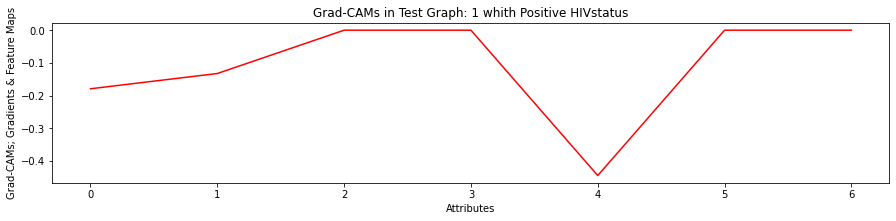

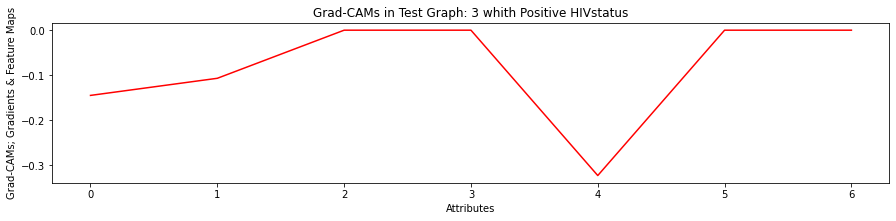

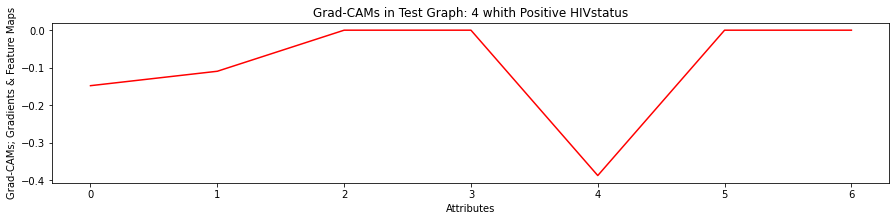

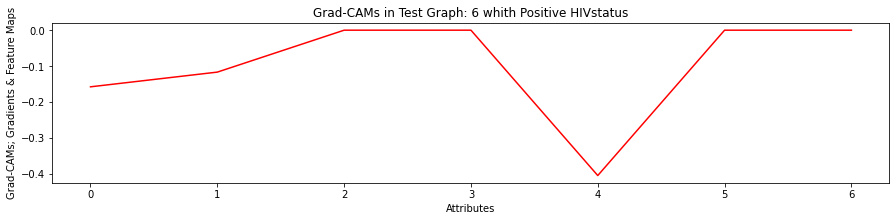

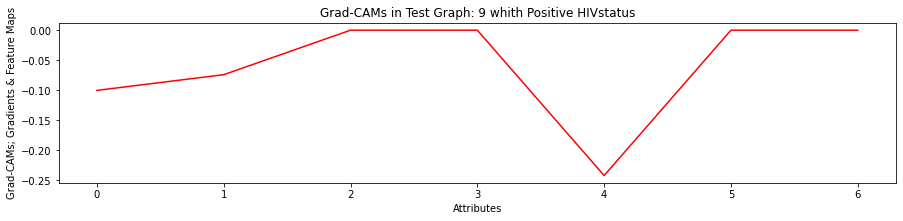

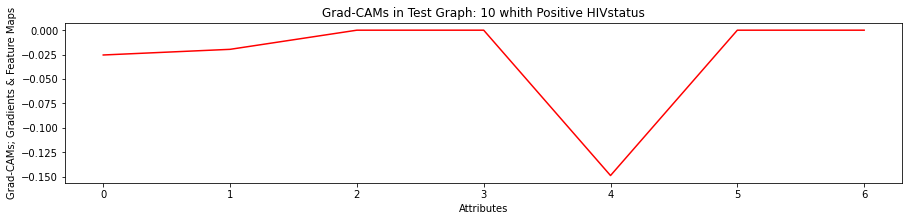

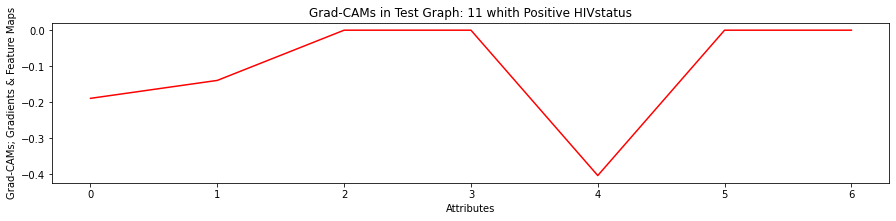

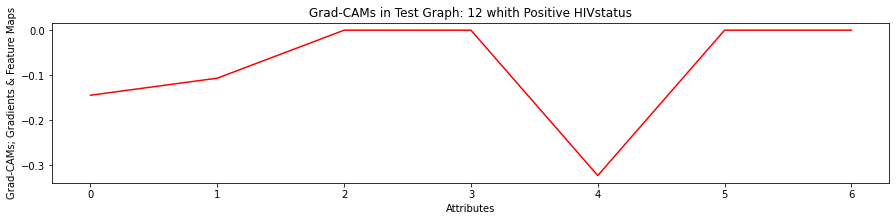

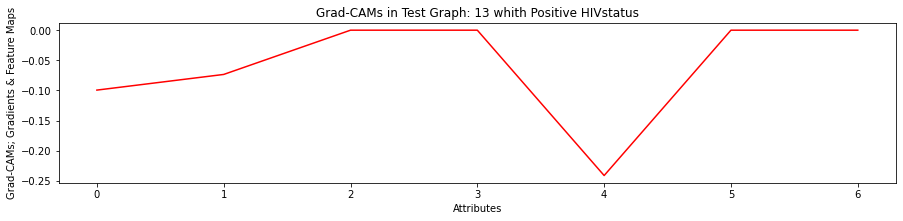

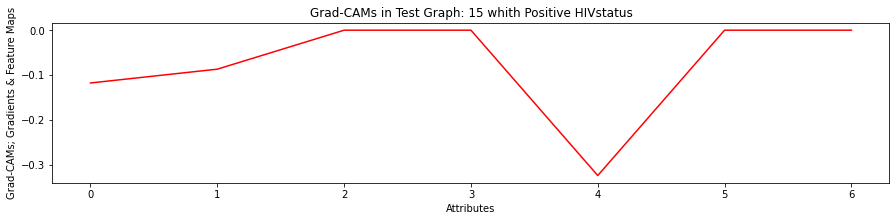

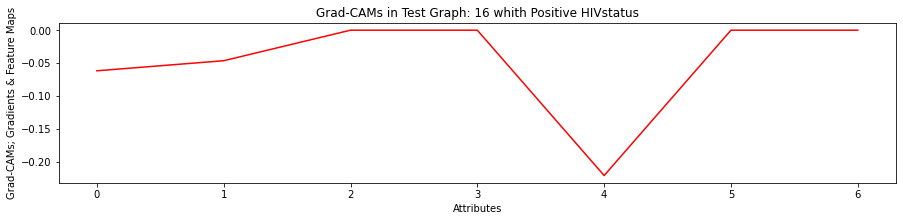

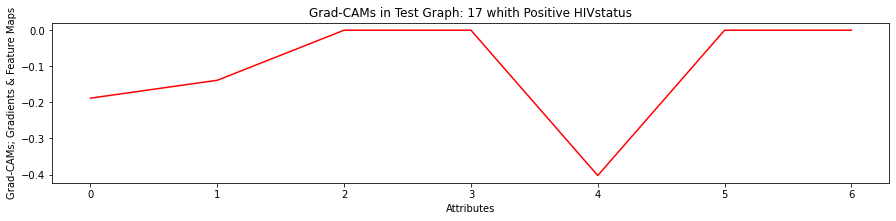

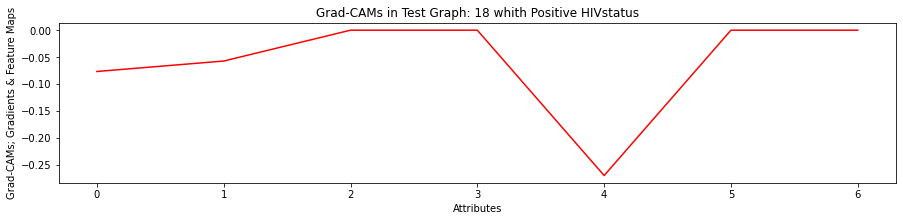

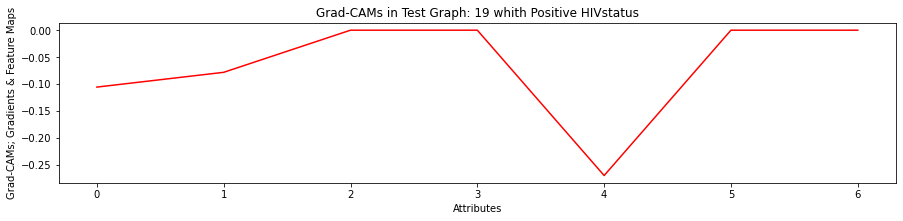

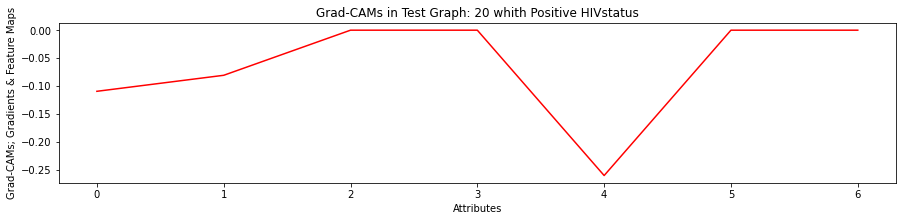

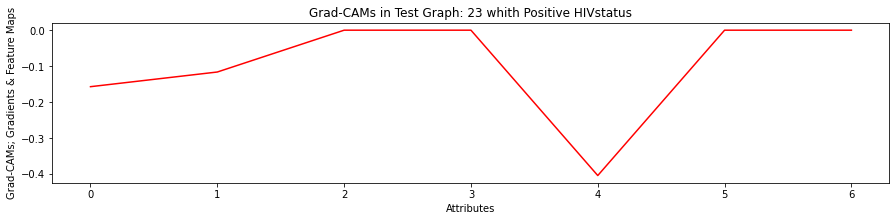

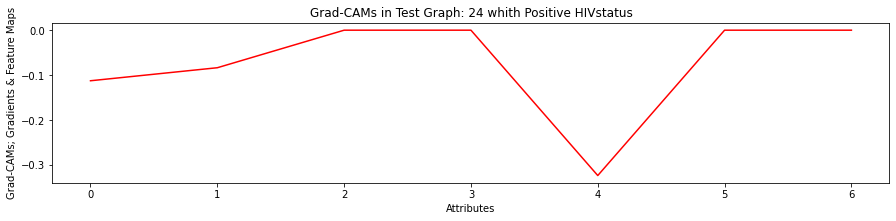

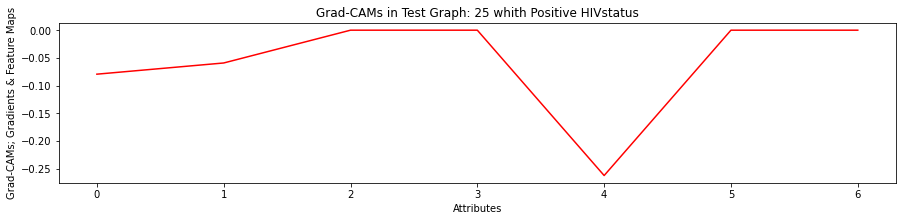

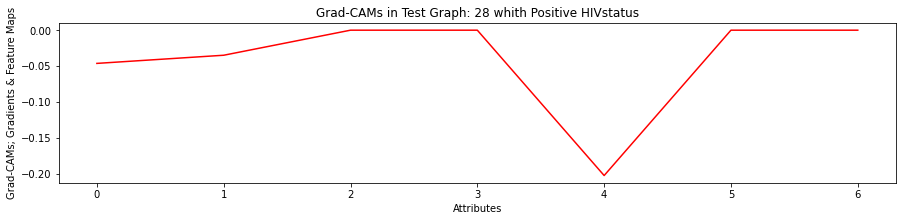

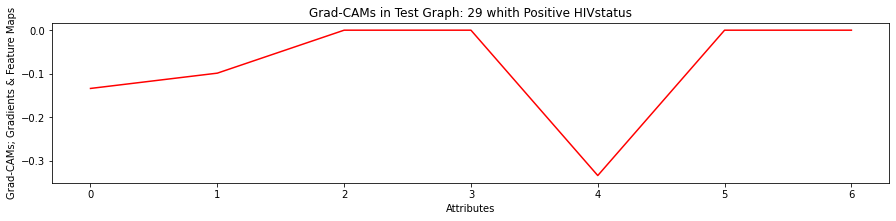

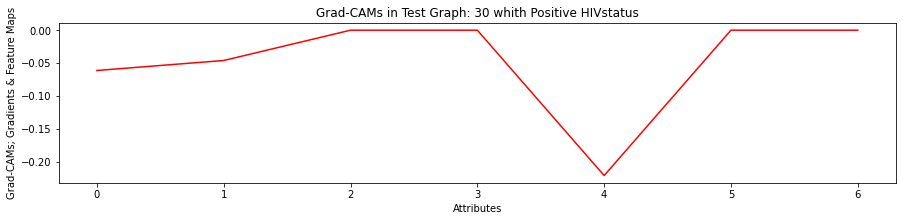

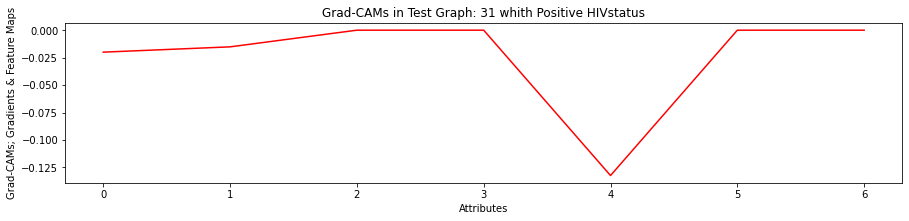

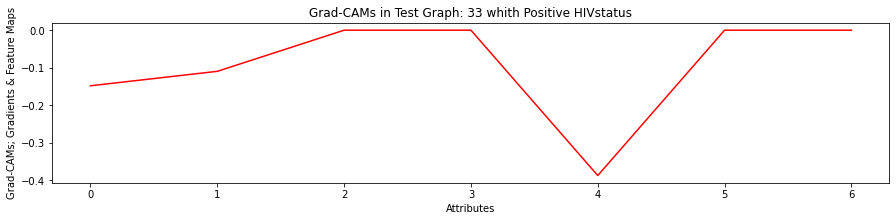

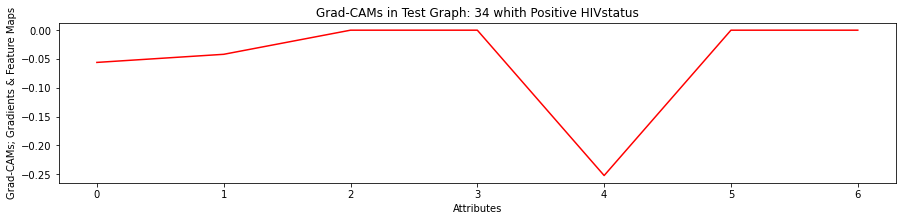

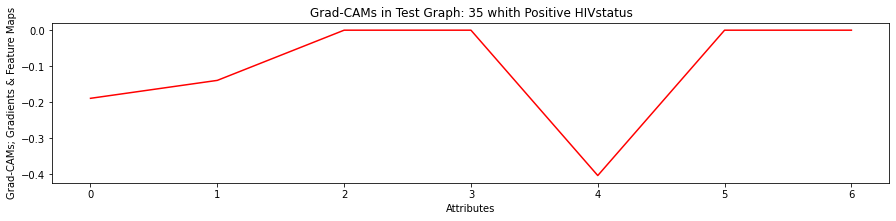

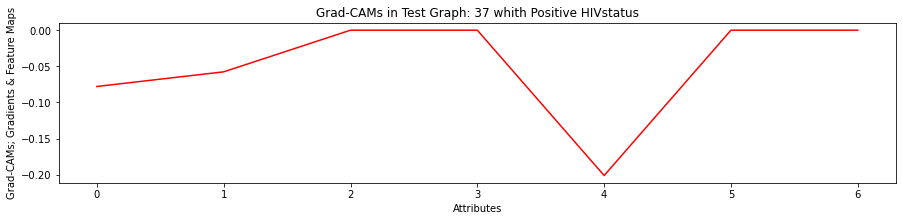

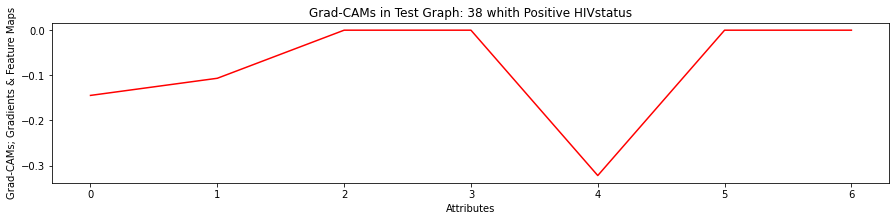

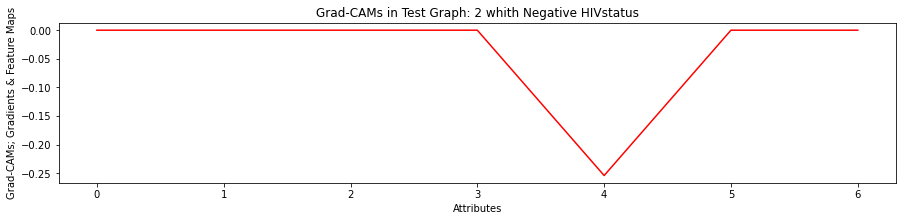

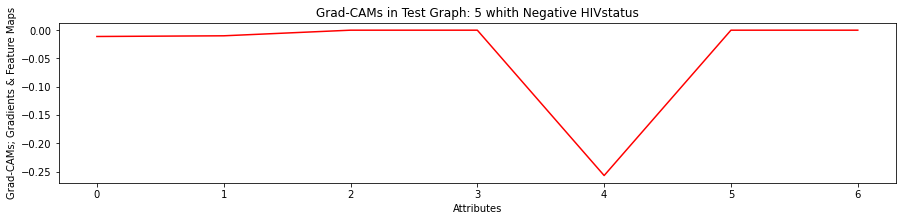

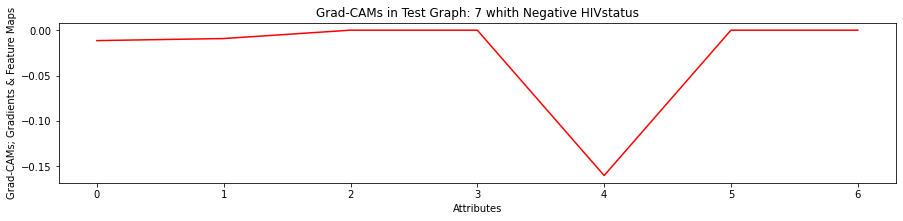

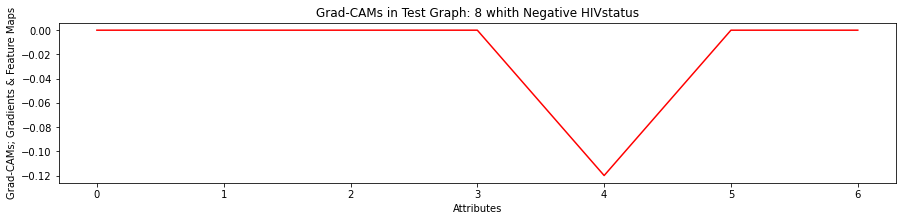

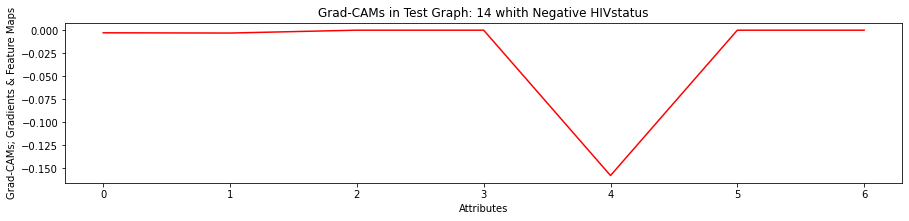

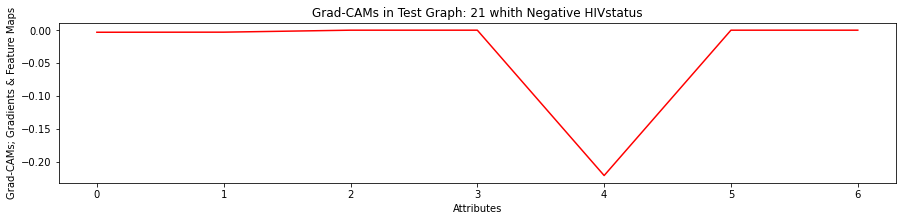

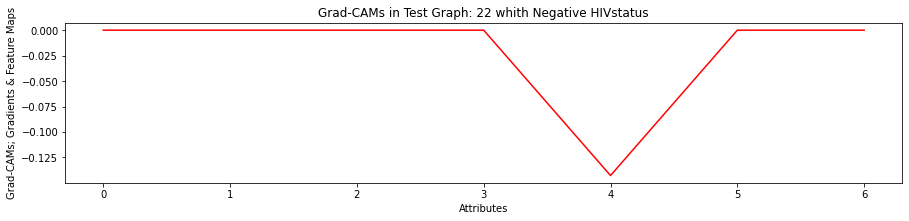

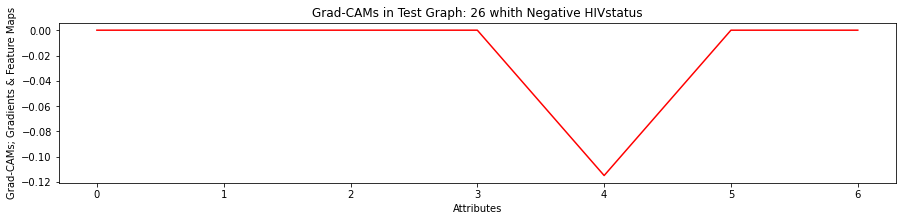

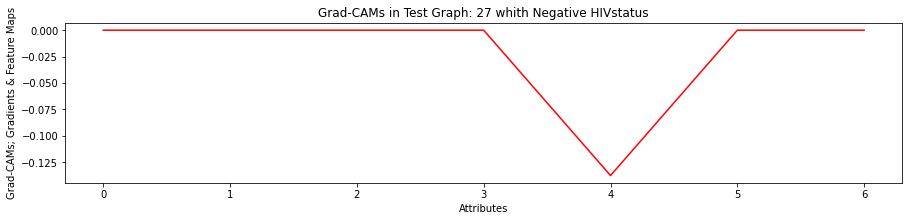

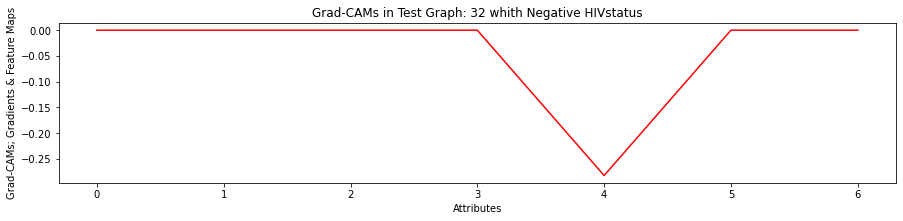

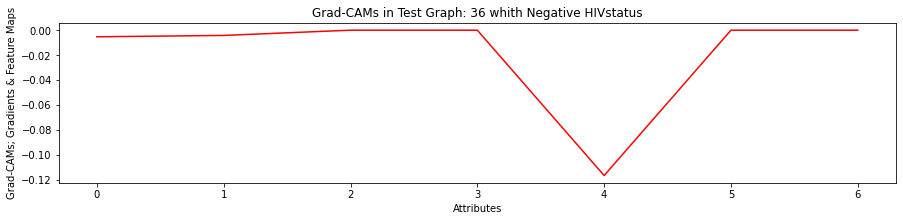

In [ ]:
HIV_status = "Positive HIV"
for i in range(len(HIV_POS)):
  visualize_Grad_CAMs(HIV_POS[i], HIV_POS_index[i], HIV_status)

HIV_status = "Negative HIV"
for i in range(len(HIV_NEG)):
  visualize_Grad_CAMs(HIV_NEG[i], HIV_NEG_index[i], HIV_status)

In [ ]:
#print(Weights_of_the_Winner_Node[0])
#print('***********************************')
#print(Feature_Maps_of_the_Last_Conv[0][0])
#print('===================================')
#print(CAMs_of_Nodes_for_each_graph[0][0])

In [ ]:
#print(np.shape(FeatureMaps_of_the_Last_Conv))
#for i in range(len(FeatureMaps_of_the_Last_Conv[0])):
#  print(FeatureMaps_of_the_Last_Conv[0][i])

In [ ]:
#CAM_model_GCN.eval()
#x = []
#for batched_data in test_dataset:  
#    Last_Conv, GAP, cam_preds = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
#    x.append(Last_Conv)

In [ ]:
#print('CAM_Test_Last_Conv')
#print(CAM_Test_Last_Conv)
#print("=========================================================================")
#print(len(x))

#summ = 0
#for i in range(len(x)):
#  print(len(x[i]), test_dataset[i].num_nodes)
#  summ=summ+len(x[i])
#print(summ)

# **Upto the last Conv layer**

# **Gradients of CAM**


In [ ]:
'''def accumulate_gradients(model_for_you):
  before_CAM = []
  after_CAM = []
  
  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv2.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv3.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv3.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "lin.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
  

  return before_CAM, after_CAM'''

In [ ]:
#holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(CAM_model_GCN)

In [ ]:
#print(len(holder_of_new_gradients))

8
